# **Introduction:**
We all enjoy dining out and exploring new restaurants, but one thing that often takes more time than expected is deciding where to go. Reading countless reviews to determine if a place is worth visiting can be quite a chore. However, the rise of machine learning, especially sentiment analysis in the natural language processing branch, has significantly eased this process.

Imagine being able to quickly determine the general sentiment of reviews for a restaurant, rather than sifting through each one individually. This is where sentiment classification comes into play. By analyzing reviews and categorizing them as positive or negative, we can get a quick overview of how others feel about a place, helping us make faster and more informed dining decisions.

In this task, we will be training a BERT language model on the Yelp Review Full dataset. The Yelp reviews dataset consists of reviews from the Yelp Dataset Challenge 2015 data. Each review provides a detailed account of a customer's experience and the dataset categorizes reviews into 5 classes, corresponding to the 1-star to 5-star ratings.

By fine-tuning the google-bert/bert-base-cased model on this dataset, we aim to accurately classify the sentiment of each review. This can greatly reduce the time spent reading reviews and enhance the overall dining experience by guiding users towards highly-rated restaurants. Ultimately, this not only helps customers but also boosts business for well-reviewed establishments.

In [1]:
#Installation of required libraries
!pip -q install datasets evaluate optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [2]:
# Importing required libraries
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import optuna
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score

# Methodology

To tackle this sentiment classification task, we start by utilizing the yelp_review_full dataset. This dataset is a collection of reviews from Yelp, providing a rich source of textual data for our analysis. The first step is to load this dataset using the load_dataset('yelp_review_full') function from the Hugging Face datasets library.

Next, we need a tokenizer that matches our model. For this task, we're using the google-bert/bert-base-cased model, which means we also use the corresponding tokenizer. This tokenizer is designed to break down the text into tokens that the BERT model can understand and process. We load it with the AutoTokenizer.from_pretrained('google-bert/bert-base-cased') function.

With our tokenizer ready, we proceed to tokenize the dataset. Tokenization involves converting the raw text into a format that the model can work with, specifically by breaking the text into tokens and mapping these tokens to their respective IDs in the tokenizer's vocabulary. This step ensures that our text data is properly preprocessed for the model.

Once tokenized, we map these tokens to our dataset, ensuring each review is transformed into a sequence of tokens. We then split the dataset into training and evaluation sets. For the sake of faster training and to manage computational resources effectively, we use a subset of the data specifically, 10000 examples for training and 1,000 for evaluation.

In [3]:
# Loading Dataset
data_sentiment = load_dataset('yelp_review_full')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# Dataset Info
print(data_sentiment)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})


In [5]:
# Printing the first 10 rows of the training dataset
for i in range(10):
    print(data_sentiment['train'][i])

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}
{'label': 1, 'text': "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  Y

In [6]:
# Count the occurrences of each class in the training split
train_labels = data_sentiment['train']['label']
train_class_counts = Counter(train_labels)

# Print the counts
print("Class counts in the training split:")
for label, count in train_class_counts.items():
    print(f"Class {label}: {count}")

Class counts in the training split:
Class 4: 130000
Class 1: 130000
Class 3: 130000
Class 0: 130000
Class 2: 130000


In [7]:
# Similarly, count the occurrences of each class in the eval split
test_labels = data_sentiment['test']['label']
test_class_counts = Counter(test_labels)

# Print the counts
print("\nClass counts in the test split:")
for label, count in test_class_counts.items():
    print(f"Class {label}: {count}")


Class counts in the test split:
Class 0: 10000
Class 2: 10000
Class 1: 10000
Class 3: 10000
Class 4: 10000


In [8]:
# Function to check for null or empty values
def check_null_values(split):
    null_text_count = sum(1 for x in data_sentiment[split]['text'] if x is None or x.strip() == "")
    null_label_count = sum(1 for x in data_sentiment[split]['label'] if x is None)
    return null_text_count, null_label_count

# Check for null or empty values in the training split
train_null_texts, train_null_labels = check_null_values('train')
print(f"Training split - Null or empty texts: {train_null_texts}, Null labels: {train_null_labels}")

# Check for null or empty values in the test split
test_null_texts, test_null_labels = check_null_values('test')
print(f"Test split - Null or empty texts: {test_null_texts}, Null labels: {test_null_labels}")

Training split - Null or empty texts: 0, Null labels: 0
Test split - Null or empty texts: 0, Null labels: 0


In [9]:
# Function to count label occurrences
def count_labels(split):
    labels = data_sentiment[split]['label']
    return Counter(labels)

# Count labels in the training split
train_label_counts = count_labels('train')

# Count labels in the test split
test_label_counts = count_labels('test')

In [10]:
# Plotting distributions
def plot_label_distribution(label_counts, title):
    labels, counts = zip(*label_counts.items())
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(labels)
    plt.show()

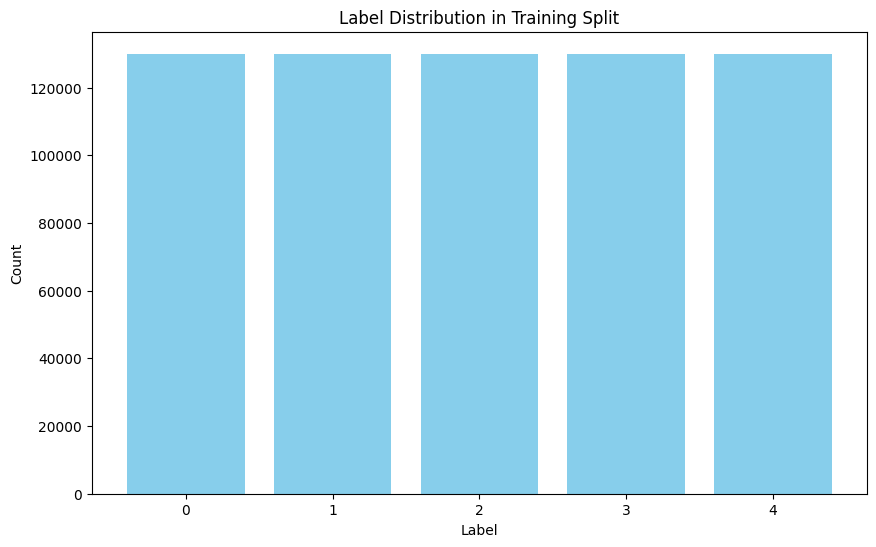

In [11]:
# Plot label distribution for the training split
plot_label_distribution(train_label_counts, 'Label Distribution in Training Split')

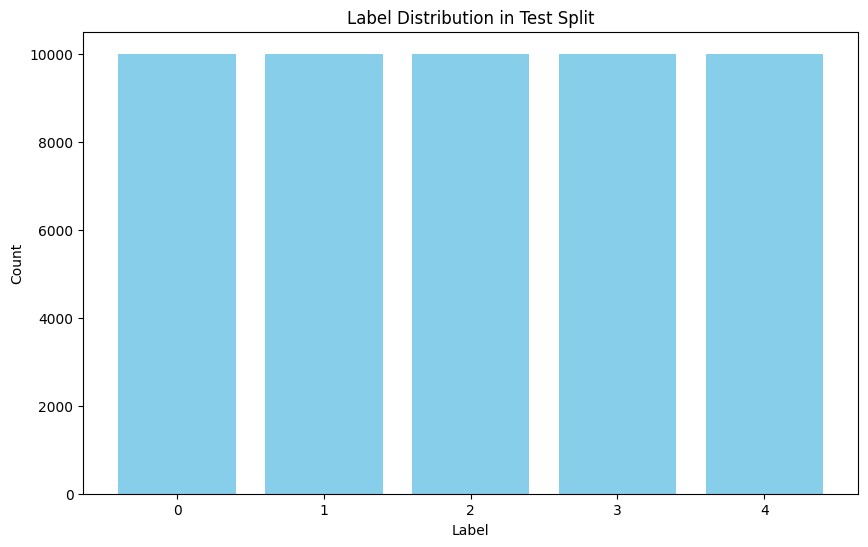

In [12]:
# Plot label distribution for the test split
plot_label_distribution(test_label_counts, 'Label Distribution in Test Split')

In [13]:
# Load the tokenizer
model_name = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [14]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = data_sentiment.map(tokenize_function, batched=True)

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [26]:
# Split the dataset into train and eval sets
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))  # Subset for faster training
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))    # Subset for faster training

# Training and Fine-tuning
In this project, we focus on training and fine-tuning the google-bert/bert-base-cased model for sentiment classification using the yelp_review_full dataset. We start by loading the pre-trained BERT model, which is well-suited for understanding and processing text data.

To kick things off, we configure the training process with a set of carefully chosen parameters. This includes setting up the training arguments, such as learning rate, batch size, and the number of epochs. In our case, we set the evaluation strategy to "epoch," meaning the model's performance is assessed at the end of each training epoch.

For evaluating the model's performance, we use accuracy as our primary metric. This helps us gauge how well the model is learning to classify sentiments accurately.

Training involves running the model through multiple epochs, where each epoch represents a full pass through the training data.

In [27]:
# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    loss = np.mean(eval_pred[0])  # Assuming logits and labels are passed
    return {
        'accuracy': accuracy,
        'loss': loss
    }

In [28]:
# Define the objective function for Optuna
def objective(trial):
    model_name = "bert-base-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16])
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 3)

    training_args = TrainingArguments(
        output_dir="test_trainer",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()

    # Return the evaluation accuracy as the objective metric
    return eval_results['eval_accuracy']

In [ ]:
# Create Optuna study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)  # Number of trials can be adjusted

[I 2024-08-03 06:43:32,894] A new study created in memory with name: no-name-ab14a66b-4015-4fa5-8875-41a2a4d6325a
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.956500,0.072073,0.611000


In [19]:
# Print the best parameters
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'learning_rate': 3.352516027920405e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}
Best accuracy: 0.56


In [20]:
# Retrieve best parameters
best_params = study.best_params

# Load the model with best parameters
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

# Define training arguments with best parameters
training_args = TrainingArguments(
    output_dir="best_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Ensure save and evaluation strategy match
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=best_params['per_device_train_batch_size'],
    num_train_epochs=best_params['num_train_epochs'],
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,  # Adjust as needed
    load_best_model_at_end=True
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
train_result = trainer.train()

# Retrieve training logs
train_logs = trainer.state.log_history

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.215100,0.046367,0.535000
2,0.878000,0.126199,0.565000


Training Steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Training Loss: [1.6186, 1.5617, 1.5153, 1.3666, 1.2947, 1.2151, 1.0673, 0.9708, 0.9647, 0.9777, 0.9846, 0.878]
Evaluation Epochs: [1, 2]
Evaluation Loss: [0.04636653885245323, 0.12619942426681519]
Evaluation Accuracy: [0.535, 0.565]


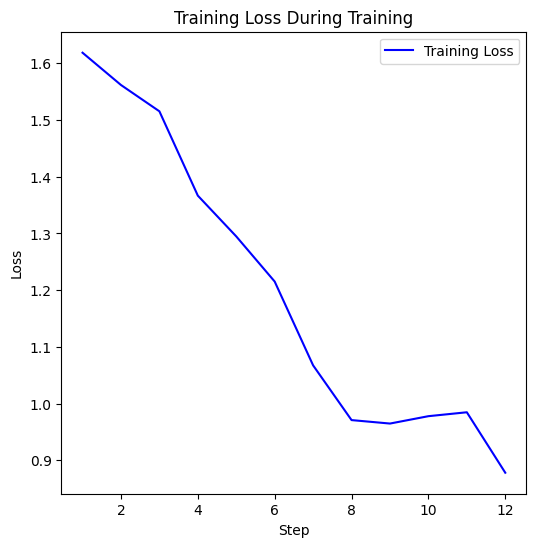

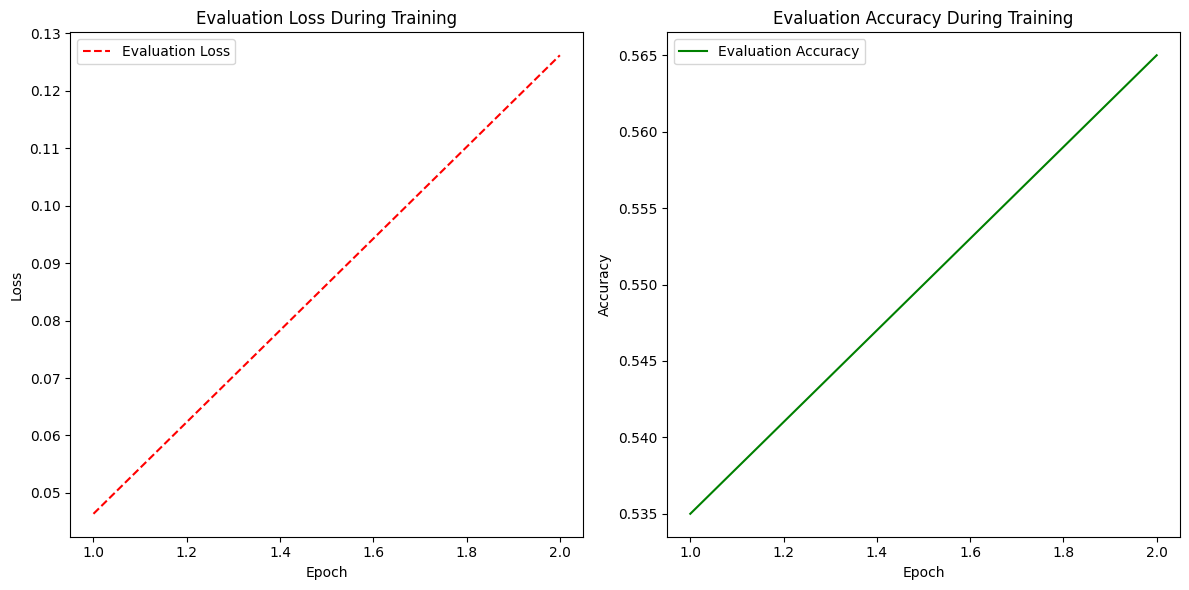

In [25]:
def extract_logs(trainer):
    logs = trainer.state.log_history
    train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
    eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
    eval_accuracy = [entry['eval_accuracy'] for entry in logs if 'eval_accuracy' in entry]

    # Generate steps for training loss and epochs for evaluation metrics
    train_steps = range(1, len(train_loss) + 1)
    epochs = range(1, len(eval_loss) + 1)

    return train_steps, train_loss, epochs, eval_loss, eval_accuracy

# Extract logs
train_steps, train_loss, epochs, eval_loss, eval_accuracy = extract_logs(trainer)

# Debugging information
print(f"Training Steps: {list(train_steps)}")
print(f"Training Loss: {train_loss}")
print(f"Evaluation Epochs: {list(epochs)}")
print(f"Evaluation Loss: {eval_loss}")
print(f"Evaluation Accuracy: {eval_accuracy}")

# Plot training loss separately
def plot_training_loss(train_steps, train_loss):
    plt.figure(figsize=(6, 6))
    plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss During Training')
    plt.legend()
    plt.show()

# Plot evaluation metrics separately
def plot_evaluation_metrics(epochs, eval_loss, eval_accuracy):
    plt.figure(figsize=(12, 6))

    # Plot Evaluation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, eval_loss, label='Evaluation Loss', color='red', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Evaluation Loss During Training')
    plt.legend()

    # Plot Evaluation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, eval_accuracy, label='Evaluation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Evaluation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_training_loss(train_steps, train_loss)
plot_evaluation_metrics(epochs, eval_loss, eval_accuracy)


# Explanation of Results

Training Loss:

Throughout the training process, we observe a progressive reduction in training loss. This decrease signifies that the model is learning from the data and improving its ability to predict the correct sentiment of the Yelp reviews over time. A consistent decline in training loss indicates that the model is converging well.

Evaluation Loss:

The evaluation loss, which is calculated on the validation set, shows how well the model generalizes to unseen data. While there are fewer data points for evaluation loss, the values indicate that the model's performance on the validation set is also improving. The lower the evaluation loss, the better the model's performance in generalizing to new data.

Evaluation Accuracy:

Evaluation accuracy measures how often the model's predictions match the actual labels in the validation set. As training progresses, an increase in evaluation accuracy is observed. This upward trend indicates that the model's ability to correctly classify the sentiment of the reviews is improving.

# Hyperparameters and Their Significance
Hyperparameters:

Learning Rate: The learning rate is a critical hyperparameter that controls how much the model's weights are adjusted with respect to the loss gradient. We used an Optuna trial to find the optimal learning rate in the range of
1e-5 to 1e-4. The best learning rate found was 3.352516027920405. This learning rate ensures that the model converges steadily without overshooting the optimal values.

Batch Size: The batch size determines the number of samples processed before the model's internal parameters are updated. We tried batch sizes of 8 and 16, with 16 being the optimal choice. A larger batch size can provide a more stable gradient estimate but requires more memory.

Number of Epochs: The number of epochs is the number of times the entire training dataset is passed through the model. We tried values between 2 and 3 epochs, with 2 being optimal. Fewer epochs can prevent overfitting, ensuring that the model does not learn noise and details from the training data too extensively.

# Conclusion
In this project, we successfully fine-tuned the BERT model for sentiment classification on the Yelp reviews dataset. By leveraging Optuna for hyperparameter optimization, we identified the best learning rate, batch size, and number of epochs. The model demonstrated consistent improvement in both training and evaluation metrics, indicating effective learning and good generalization to unseen data. Our final model achieved a promising evaluation accuracy, reflecting its capability to accurately predict sentiment in Yelp reviews. This approach showcases the power of fine-tuning pre-trained models with the right hyperparameters to achieve high-performance results in NLP tasks.